---
# Zadaća 8
##### Rok za predaju: 14. svibnja, 2021. u 23:59h
##### Način predaje: Teams->Strojno učenje->Assignment, predajete.ipynb datoteka (ili više datoteki u .zip) ili link na Google colab 

### Ime i prezime: Borna Gajić

---

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Zadatak 1
U sljedećim zadacima trebate složiti četiri modela neuronskih mreža za učenje na danim podacima `data-x.npy, data-y.npy`. <br>
Mreže složite koristeći `PyTorch` (tako da možete proizvoljno odabrati početne vrijednosti za težine). <br>
Upute za arhitekturu mreže:
- broj aktivacijskih jedinica u ulaznom sloju je određen brojem varijabli u `data-x.npy`
- jedan skriveni sloj neka ima `100` aktivacijskih jedinica
- izlazni sloj neka ima jednu aktivacijsku jedinicu

Upute za odabir aktivacijskih funkcija i početnih težina
- aktivacijski funkcija na izlaznom sloju neka bude identiteta (bez aktivacijske funkcije) u svakom slučaju
- aktivacijska funkcija na skrivenom sloju
    - aktivacijska funkcija je sigmoid, početne težine su sve postavljene na 10
    - aktivacijska funkcija je simoid, početne težine su slučajno generirani brojevi između 0-1
    - aktivacijska funkcija je ReLU, početne težine su sve postavljene na 0
    - aktivacijska funkcija je ReLu, početne težine su slučajno generirani brojevi između 0-1

Kada budete trenirali svaki od ovih slučajeva, fiksirajte broj iteracija na 50, te ispišite kretanje vrijednosti funkciju pogreške. Što primjećujete? Kako to interpretirate?

In [2]:
class trainData (Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Učitavanje podataka

In [10]:
data_x = np.load('./data-x.npy').astype(np.float32)
data_y = np.load('./data-y.npy').astype(np.float32)

m, n = data_x.shape

print("dim data_x =", data_x.shape)
print("dim data_y =", data_y.shape)

dim data_x = (30, 2)
dim data_y = (30, 1)


Pretvaranje u tenzore

In [11]:
train_data1 = trainData(torch.FloatTensor(data_x), torch.FloatTensor(data_y))

train_loader1 = DataLoader(dataset = train_data1, batch_size = 1, shuffle = True)

Klase za definiranje Dataseta i Dataloadera

`CustomModel` je klasa koja za parametre prima:  
 * `sequential`, field za `torch.nn.modules.container.Sequential`
 * `get_weight`, metoda koja vraća težinu
 * `loss_function`, field koji prima funkciju troška
 * `train_loader`, DataLoader skupa za treniranje
 * `epochs`, broj iteracija treniranja modela
 * `learning_rate`, konstanta koja se množi s gradijentom (stopa učenja)
 * `max_iter`, maksimalni broj iteracija za učenje modela
 * `optim`, boolean koji dozvoljava ili onemogućuje optimizacijski korak u momentu učenja modela

In [326]:
class CustomModel (nn.Module):
    def __init__ (self, sequential, get_weight, loss_function, train_loader, epochs, learning_rate, optim):
        super(CustomModel, self).__init__()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = sequential
        self.get_weight = get_weight
        self.loss_fn = loss_function
        self.loss_values = []
        self.optim = optim
        self.train_loader = train_loader
        
        if self.get_weight() != None:
            self.model.apply(self.init_weights)
        if self.optim == True:
            self.optimizer = torch.optim.AdamW(self.model.parameters(), self.learning_rate)
        
    def init_weights (self, m):
        with torch.no_grad():
            if type(m) == nn.Linear:
                m.weight.fill_(self.get_weight())
        
    def forward (self, X_batch):
        return self.model(X_batch)
    
    def backward (self, y_pred, y_batch):
        if self.optim == True: self.optimizer.zero_grad()
            
        loss = self.loss_fn(y_pred, y_batch)
        loss.backward()
        
        if self.optim == False:
            with torch.no_grad():
                for w in self.model.parameters():
                    w -= self.learning_rate * w.grad
        else:
            self.optimizer.step()
                    
        return loss.item()
                
    def train (self):
        self.model.train()
        for e in range(self.epochs):
            epoch_loss = 0
            for X_batch, y_batch in self.train_loader:
                
                y_pred = self.forward(X_batch)
                epoch_loss += self.backward(y_pred, y_batch)
                
            self.loss_values.append(epoch_loss / len(self.train_loader))
    
    def draw_loss (self):
        plt.plot(np.arange(self.epochs), self.loss_values, c = 'r')
        plt.show()

Određivanje veličine mreže

In [12]:
inputSize = n
hiddenSize = 100
outputSize = 1

### 1. Model 
> Aktivacijska funkcija je sigmoid, početne težine su sve postavljene na 10.

Specifikacije za prvi model

In [23]:
sequential_1 = nn.Sequential(
               nn.Linear(inputSize, hiddenSize),
               nn.Sigmoid(),
               nn.Linear(hiddenSize, outputSize))

def get_weight_1 ():
    return 10.0

loss_function = nn.MSELoss()

Treniranje prvog modela

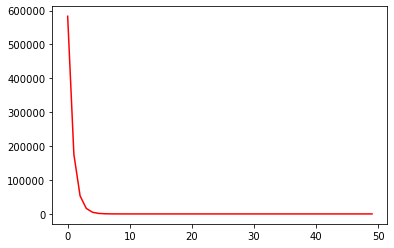

In [24]:
model1 = CustomModel(sequential_1, get_weight_1, loss_function, train_loader1, 50, 1e-4, True)
model1.train()
model1.draw_loss()

Grafički prikaz funkcije troška

### 2. Model

> Aktivacijska funkcija je simoid, početne težine su slučajno generirani brojevi između 0-1

Specifikacija drugog modela

In [34]:
sequential_2 = nn.Sequential(
               nn.Linear(inputSize, hiddenSize),
               nn.Sigmoid(),
               nn.Linear(hiddenSize, outputSize))

def get_weight_2 ():
    return np.random.rand()

loss_function = nn.MSELoss()

Treniranje drugog modela

Linear(in_features=2, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)


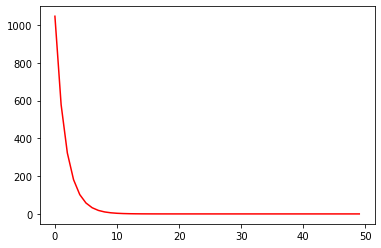

In [35]:
model2 = CustomModel(sequential_2, get_weight_2, loss_function, train_loader1, 50, 1e-4, True)
model2.train()
model2.draw_loss()

### 3. Model
>aktivacijska funkcija je ReLU, početne težine su sve postavljene na 0

Specifikacija trećeg modela

In [31]:
sequential_3 = nn.Sequential(
               nn.Linear(inputSize, hiddenSize),
               nn.ReLU(),
               nn.Linear(hiddenSize, outputSize))

def get_weight_3 ():
    return 0

loss_function = nn.MSELoss()

Treniranje trećeg modela

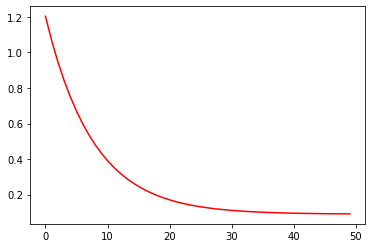

In [32]:
model3 = CustomModel(sequential_3, get_weight_3, loss_function, train_loader1, 50, 1e-4, True)
model3.train()
model3.draw_loss()

### 4. Model
>Aktivacijska funkcija je ReLu, početne težine su slučajno generirani brojevi između 0-1

Specifikacije četvrtog modela

In [14]:
sequential_4 = nn.Sequential(
               nn.Linear(inputSize, hiddenSize),
               nn.ReLU(),
               nn.Linear(hiddenSize, outputSize))

def get_weight_4 ():
    return np.random.rand()

loss_function = nn.MSELoss()

Treniranje četvrtog modela

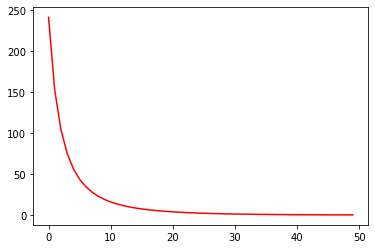

In [15]:
model4 = CustomModel(sequential_4, get_weight_4, loss_function, train_loader1, 50, 1e-4, False)
model4.train()
model4.draw_loss()

**Komentari** 
 * Najbrže se trenirao model koji za aktivacijsku funkciju ima Sigmoid, a težine su mu postavljene na vrijednosti između $[0, 1]$
 * Pogreške kod modela sa random vrijednostima između $[0, 1]$ su imali najveće vrijednosti funkcije troška, ali opet, i najbrže je ta pogreška degradirala


## Zadatak 2

1. Promotrimo dvosloju neuronsku mrežu kao na slici , koja ima dodatni parametar koji odgovara direktnoj vezi između ulaza i izlaza. Na vježbama smo detaljno proučili sličnu neuronsku mrežu koja nije imala taj dodatni parametar. Analogno tome, provedite backpropagacijski algoritam i zapišite sve parcijalne derivacije.  
<img src="./zadatak_2.png" width = "30%">

2. Implementirajte navedenu neuronsku mrežu i proces njenog učenja. Generirajte neki skup podataka koristeći `sklearn.datasets.make_regression`  i naučite ga na implementiranoj mreži. 

In [ ]:
# Vaš kod

## Zadatak 3

Zadani su vam podaci `employees.csv`, predstavljeni na vježbama. <br>
Vaš je zadatak klaisficirati dane podatke koristeći neuronsku mrežu. <br>
Arhitektura mreže, izbor hiperparametara je proizvoljan. <br>
Također, u procesu učenja upotrijebite neke od pokazanih metoda. 

In [37]:
employees = pd.read_csv('./employees.csv')
employees

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Izmjenimo određene stupce `employees.csv` filea

In [38]:
employees_edited = employees.copy()

Grafički prikazi podataka:
 * CreditScore

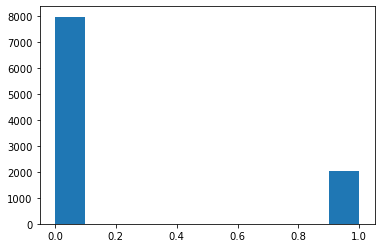

In [39]:
plt.hist(employees['Exited'])
plt.show()

 * Balance

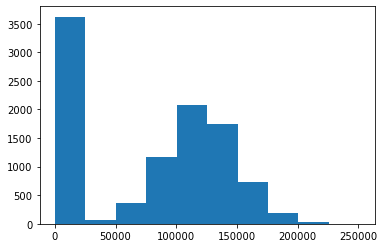

In [19]:
plt.hist(employees['Balance'])
plt.show()

 * Age

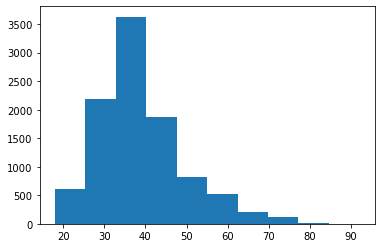

In [20]:
plt.hist(employees['Age'])
plt.show()

In [40]:
le = LabelEncoder()
scaler = StandardScaler()

employees_edited['Geography'] = le.fit_transform(employees_edited['Geography'])
employees_edited['Gender'] = le.fit_transform(employees_edited['Gender'])

employees_edited['CreditScore'] = scaler.fit_transform(employees_edited['CreditScore'].to_numpy().reshape(-1, 1))
employees_edited['Balance'] = scaler.fit_transform(employees_edited['Balance'].to_numpy().reshape(-1, 1))
employees_edited['EstimatedSalary'] = scaler.fit_transform(employees_edited['EstimatedSalary'].to_numpy().reshape(-1, 1))
employees_edited['Age'] = scaler.fit_transform(employees_edited['Age'].to_numpy().reshape(-1, 1))

In [41]:
employees_edited

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,-0.326221,0,0,0.293517,2,-1.225848,1,1,1,0.021886,1
1,2,15647311,Hill,-0.440036,2,0,0.198164,1,0.117350,1,0,1,0.216534,0
2,3,15619304,Onio,-1.536794,0,0,0.293517,8,1.333053,3,1,0,0.240687,1
3,4,15701354,Boni,0.501521,0,0,0.007457,1,-1.225848,2,0,0,-0.108918,0
4,5,15737888,Mitchell,2.063884,2,0,0.388871,2,0.785728,1,1,1,-0.365276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,1.246488,0,1,0.007457,5,-1.225848,2,1,0,-0.066419,0
9996,9997,15569892,Johnstone,-1.391939,0,1,-0.373958,10,-0.306379,1,1,1,0.027988,0
9997,9998,15584532,Liu,0.604988,0,0,-0.278604,7,-1.225848,1,0,1,-1.008643,1
9998,9999,15682355,Sabbatini,1.256835,1,1,0.293517,3,-0.022608,2,1,0,-0.125231,1


In [44]:
X = employees_edited.to_numpy()[:, 3:-1].astype(np.float32)
y = employees_edited.to_numpy()[:, -1].astype(np.float32)

Podjela na skup za treniranje i testiranje

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [97]:
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.reshape(-1, 1)))
test_data = testData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 1)

Definiranje veličine slojeva mreže

In [225]:
inputSize = X.shape[1]
hiddenSize1 = 32
hiddenSize2 = 32
hiddenSize3 = 32
outputSize = 1

Izgradnja i treniranje modela

### Primjer 1

In [307]:
employees_model = nn.Sequential(
                  nn.Linear(inputSize, hiddenSize1),
                  nn.ReLU(),
                  nn.Dropout(p = 0.2),
                  nn.Linear(hiddenSize1, hiddenSize2),
                  nn.ReLU(),
                  nn.Dropout(p = 0.2),
                  nn.Linear(hiddenSize2, hiddenSize3),
                  nn.Sigmoid(),
                  nn.Dropout(p = 0.1),
                  nn.Linear(hiddenSize3, outputSize))

neg_class_num = len(employees[employees['Exited'] == 0])
pos_class_num = len(employees[employees['Exited'] == 1])

# Povecanje tezina za labele definirane s 1, jer imamo unbalanced dataset 
loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([neg_class_num/pos_class_num])) 

def get_weight ():
    pass

Treniranje prvog modela (Optimizer: `SGD`)

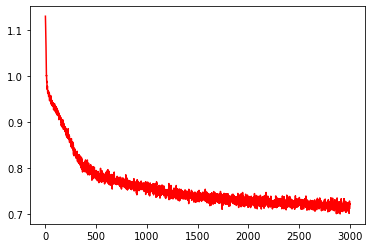

In [308]:
my_model = CustomModel(employees_model, get_weight, loss_function, train_loader, 3000, 1e-4, True)
my_model.train()
my_model.draw_loss()

Testiranje prvog modela

In [309]:
y_pred_list = []
my_model.model.eval()
with torch.no_grad():
    for X_batch in test_loader:        
        y_test_pred = my_model.model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag)

Preciznost prvog modela

In [310]:
print("Accuracy score: ", accuracy_score(y_test, y_pred_list))

Accuracy score:  0.7951515151515152


Confusion matrix

In [311]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_list).ravel()

In [312]:
print("--------------Stayed--------------Exited---------")
print("Stayed | True positive: {}  | False negative: {}".format(tp, fn))
print("Exited | False positive: {} | True negative: {}".format(fp, tn))

--------------Stayed--------------Exited---------
Stayed | True positive: 478  | False negative: 165
Exited | False positive: 511 | True negative: 2146


In [316]:
f1 = (2*tp)/(2*tp + fn + fp)
youden = tp/(tp + fn) + tn/(tn + fp) - 1
phi_coef = (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn)))

print("F1 score:", f1)
print("Youden's index:", youden)
print("Matthews correlation coefficient:", phi_coef)

F1 score: 0.5857843137254902
Youden's index: 0.5510681898398024
Matthews correlation coefficient: 0.47644029779807945


### Primjer 2

In [325]:
inputSize = X.shape[1]
hiddenSize1_2 = 64
hiddenSize2_2 = 64
hiddenSize3_2 = 64
outputSize = 1

In [327]:
employees_model_2 = nn.Sequential(
                  nn.Linear(inputSize, hiddenSize1_2),
                  nn.SELU(),
                  nn.AlphaDropout(p = 0.5),
                  nn.Linear(hiddenSize1_2, hiddenSize2_2),
                  nn.SELU(),
                  nn.AlphaDropout(p = 0.5),
                  nn.Linear(hiddenSize2_2, hiddenSize3_2),
                  nn.Sigmoid(),
                  nn.AlphaDropout(p = 0.5),
                  nn.Linear(hiddenSize3_2, outputSize))

Treniranje drugog modela (Optimizer: `AdamW`)

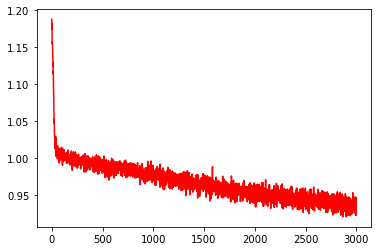

In [328]:
my_model_2 = CustomModel(employees_model_2, get_weight, loss_function, train_loader, 3000, 1e-4, True)
my_model_2.train()
my_model_2.draw_loss()

Testiranje drugog modela

In [329]:
y_pred_list_2 = []
my_model_2.model.eval()
with torch.no_grad():
    for X_batch in test_loader:        
        y_test_pred_2 = my_model_2.model(X_batch)
        y_test_pred_2 = torch.sigmoid(y_test_pred_2)
        y_pred_tag_2 = torch.round(y_test_pred_2)
        y_pred_list_2.append(y_pred_tag_2)

Preciznost drugog modela

In [330]:
print("Accuracy score: ", accuracy_score(y_test, y_pred_list_2))

Accuracy score:  0.7287878787878788


Confusion matrix

In [331]:
tn_2, fp_2, fn_2, tp_2 = confusion_matrix(y_test, y_pred_list_2).ravel()

In [332]:
print("--------------Stayed--------------Exited---------")
print("Stayed | True positive: {}  | False negative: {}".format(tp_2, fn_2))
print("Exited | False positive: {} | True negative: {}".format(fp_2, tn_2))

--------------Stayed--------------Exited---------
Stayed | True positive: 493  | False negative: 150
Exited | False positive: 745 | True negative: 1912


In [333]:
f1_2 = (2*tp_2)/(2*tp_2 + fn_2 + fp_2)
youden_2 = tp_2/(tp_2 + fn_2) + tn_2/(tn_2 + fp_2) - 1
phi_coef_2 = (tp_2 * tn_2 - fp_2 * fn_2)/(np.sqrt((tp_2 + fp_2)*(tp_2 + fn_2)*(tn_2 + fp_2)*(tn_2 + fn_2)))

print("F1 score:", f1_2)
print("Youden's index:", youden_2)
print("Matthews correlation coefficient:", phi_coef_2)

F1 score: 0.5241892610313663
Youden's index: 0.48632708810495595
Matthews correlation coefficient: 0.3978552296055653
